In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv('alg_ff_clean.csv')

In [3]:
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,encode
0,1.0,6.0,2012.0,29.0,57.0,18.0,0.0,65.7,3.4,7.6,1.3,3.4,0.5,notfire,0
1,2.0,6.0,2012.0,29.0,61.0,13.0,1.3,64.4,4.1,7.6,1.0,3.9,0.4,notfire,0
2,3.0,6.0,2012.0,26.0,82.0,22.0,13.1,47.1,2.5,7.1,0.3,2.7,0.1,notfire,0
3,4.0,6.0,2012.0,25.0,89.0,13.0,2.5,28.6,1.3,6.9,0.0,1.7,0.0,notfire,0
4,5.0,6.0,2012.0,27.0,77.0,16.0,0.0,64.8,3.0,14.2,1.2,3.9,0.5,notfire,0


Log Shrinking FWI 

In [4]:
df['FWI-log'] = np.log1p(df['FWI'])

---

### Training Set Multicollinearity

<Axes: >

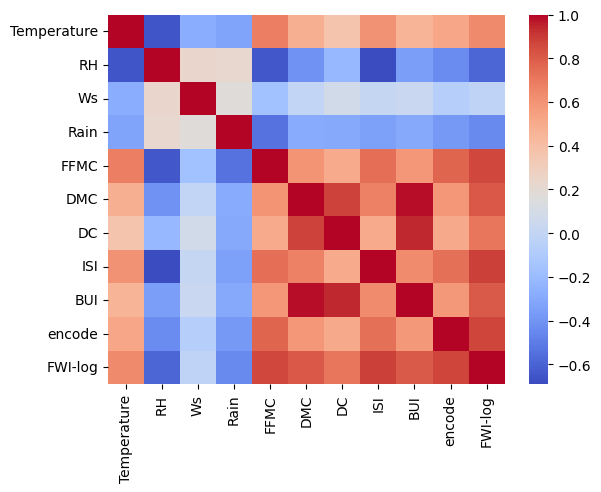

In [5]:
sns.heatmap(data=df.drop(columns=['Classes','month','day','year','FWI']).corr(), cmap = 'coolwarm')

Extracting the stongest correlated features

In [6]:
corr_matrix = df.drop(columns=['Classes','month','day','year','FWI']).corr()
max_strength_allowed = 0.85
redundant_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):  # only upper triangle, so that we don't loop on alreeady added pairs again
        feature1 = corr_matrix.columns[i]
        feature2 = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) >= max_strength_allowed: #Absolute Value, since high negative corrs are still string but in opposite directions
            redundant_pairs.append((feature1, feature2, corr_value))
redundant_pairs

[('FFMC', 'FWI-log', np.float64(0.866948553299978)),
 ('DMC', 'DC', np.float64(0.8753621017981059)),
 ('DMC', 'BUI', np.float64(0.9820732709504009)),
 ('DC', 'BUI', np.float64(0.9419063782799447)),
 ('ISI', 'FWI-log', np.float64(0.8871016386820919)),
 ('encode', 'FWI-log', np.float64(0.8709738543566308))]

BUI can be dropped, scientifically speaking, BUI is derived from both DMC and DC, which are fundamental features. 

Splitting the data for testing
- 80% Training
- 20% Testing

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Prepare features and target, then split once for the whole notebook
X = df.drop(columns=['Classes','month','day','year','FWI','FWI-log','BUI','encode']) #Date is removed to stop any data leakage from happening
Y = df['FWI-log']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.2)

--- 

Correlation & Heatmap

Data Standardization

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Standardizng both the training and testing datasets individually
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

---

### Baseline Model

Linear Regression will be used to establish a baseline onto which we evaluate our models

In [9]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

#checking model reliability 
scores_r2 = cross_val_score(lm,x_train_scaled,Y_train, cv = 2, scoring='r2') #r2 scores for 5 training samples
#We need to check the mean and variance of both
print(f'R2 score mean: {scores_r2.mean()}')
print(f'R2 score variance: {scores_r2.std()}') 
lm.fit(x_train_scaled,Y_train)
y_pred_train = lm.predict(x_train_scaled)
y_pred_test = lm.predict(x_test_scaled)
print(f'MSE Test: { mean_squared_error(Y_test, y_pred_test)}')
print("Test R2:", r2_score(Y_test, y_pred_test))

R2 score mean: 0.9497424033188666
R2 score variance: 0.0037956942688067152
MSE Test: 0.060312785023979694
Test R2: 0.9373849627769422


We can try regularization models like Ridge, Lasso and Elasticnet:
- Linear Regression slightly overfits
- The existence of multicollinearity which could result in less impactful features that can confuse the model

In [10]:
# Defining parameters 
params ={'alpha' : [0.001,0.01,0.1,1,10,100,1000] }

### Ridge Regression

It shrinks coefficients by penalizing large ones

In [11]:
from sklearn.linear_model import Ridge
ridge = Ridge(random_state=42)
random_search_ridge = RandomizedSearchCV(
    ridge,
    params,
    cv = 10,
    n_jobs=-1,
    verbose=True
)
random_search_ridge.fit(x_train_scaled,Y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


c:\Users\charb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=Ridge(random_state=42), n_jobs=-1,
                   param_distributions={'alpha': [0.001, 0.01, 0.1, 1, 10, 100,
                                                  1000]},
                   verbose=True)

In [12]:
#now random_search delegates to itself the Ridge with the best parameters, in this case Alpha
y_pred_train = random_search_ridge.predict(x_train_scaled)
y_pred_test = random_search_ridge.predict(x_test_scaled)
#------------------------------------------------ Evaluations----------------------------------------------------------
#Train Evaluation
print(f'MSE Train: { mean_squared_error(Y_train, y_pred_train)}')
print("Train R2:", r2_score(Y_train, y_pred_train))
#Test Evaluation
print(f'MSE Test: { mean_squared_error(Y_test, y_pred_test)}')
print("Test R2:", r2_score(Y_test, y_pred_test))

MSE Train: 0.04980122961734017
Train R2: 0.9555704878711153
MSE Test: 0.05997550292698823
Test R2: 0.937735119564585


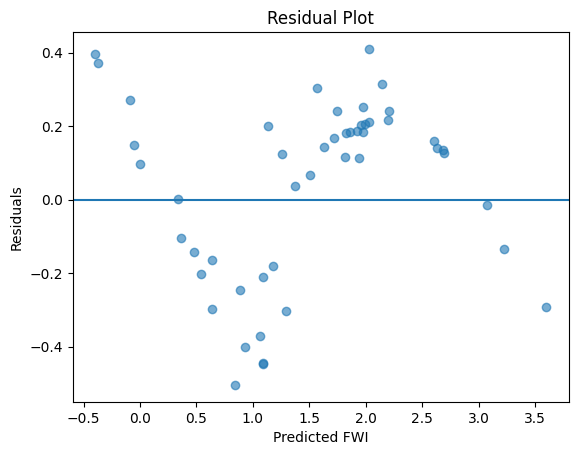

In [13]:
residuals = Y_test - y_pred_test

plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(0)
plt.xlabel("Predicted FWI")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

--- 

### Lasso Regression

Entirely removes useless variables

In [14]:
from sklearn.linear_model import Lasso
lasso = Lasso(random_state=42)
random_search = RandomizedSearchCV(
    lasso,
    params,
    cv = 10,
    n_jobs=-1,
    verbose=True
)
random_search.fit(x_train_scaled,Y_train)


Fitting 10 folds for each of 7 candidates, totalling 70 fits


c:\Users\charb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=Lasso(random_state=42), n_jobs=-1,
                   param_distributions={'alpha': [0.001, 0.01, 0.1, 1, 10, 100,
                                                  1000]},
                   verbose=True)

In [15]:
#now random_search delegates to itself the Lasso with the best parameters, in this case Alpha
y_pred_train = random_search.predict(x_train_scaled)
y_pred_test = random_search.predict(x_test_scaled)
#------------------------------------------------ Evaluations----------------------------------------------------------
#Train Evaluation
print(f'MSE Train: { mean_squared_error(Y_train, y_pred_train)}')
print("Train R2:", r2_score(Y_train, y_pred_train))
#Test Evaluation
print(f'MSE Test: { mean_squared_error(Y_test, y_pred_test)}')
print("Test R2:", r2_score(Y_test, y_pred_test))

MSE Train: 0.05114838554387404
Train R2: 0.9543686404260355
MSE Test: 0.05843503684418855
Test R2: 0.9393343881289037


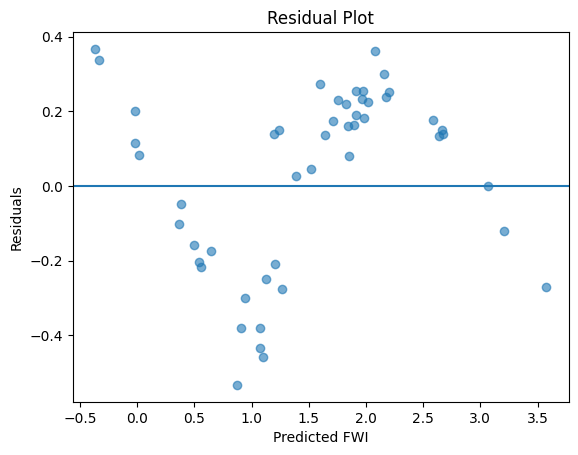

In [16]:
residuals = Y_test - y_pred_test

plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(0)
plt.xlabel("Predicted FWI")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

---

### ElasticNet Regression

Combining both Lasso and Ridge

In [17]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(random_state=42)
from sklearn.linear_model import Lasso
lasso = Lasso(random_state=42)
random_search = RandomizedSearchCV(
    elastic,
    params,
    cv = 10,
    n_jobs=-1,
    verbose=True
)
random_search.fit(x_train_scaled,Y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


c:\Users\charb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=ElasticNet(random_state=42), n_jobs=-1,
                   param_distributions={'alpha': [0.001, 0.01, 0.1, 1, 10, 100,
                                                  1000]},
                   verbose=True)

In [18]:
#now random_search delegates to itself the ElasticNet with the best parameters, in this case Alpha
y_pred_train = random_search.predict(x_train_scaled)
y_pred_test = random_search.predict(x_test_scaled)
#------------------------------------------------ Evaluations----------------------------------------------------------
#Train Evaluation
print(f'MSE Train: { mean_squared_error(Y_train, y_pred_train)}')
print("Train R2:", r2_score(Y_train, y_pred_train))
#Test Evaluation
print(f'MSE Test: { mean_squared_error(Y_test, y_pred_test)}')
print("Test R2:", r2_score(Y_test, y_pred_test))

MSE Train: 0.050362522109425684
Train R2: 0.9550697381551629
MSE Test: 0.058873595597411774
Test R2: 0.9388790887649852


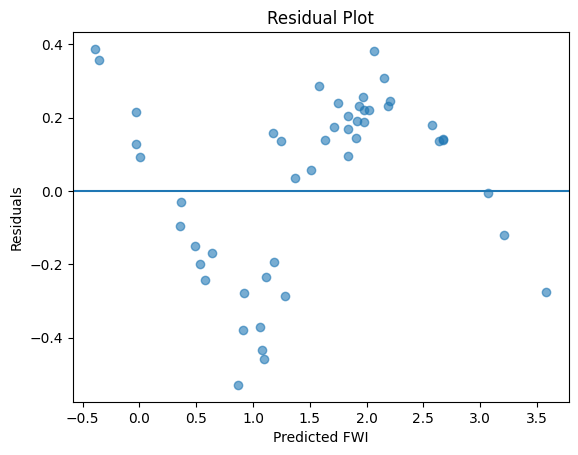

In [19]:
residuals = Y_test - y_pred_test

plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(0)
plt.xlabel("Predicted FWI")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

---

### Linear Models Results

| Model        | Train MSE  | Train R²   | Test MSE  | Test R²  |
|--------------|------------|------------|-----------|----------|
| Linear       | 0.06031    | 0.94974    | 0.06031   | 0.93738  |
| Ridge        | 0.04980    | 0.95557    | 0.05998   | 0.93774  |
| Lasso        | 0.05115    | 0.95437    | 0.05844   | 0.93933  |
| ElasticNet   | 0.05036    | 0.95507    | 0.05887   | 0.93888  |


All linear and regularized models achieved nearly identical performance,
indicating that the underlying relationships are well approximated by a
linear model and that no significant overfitting was present to be corrected
by regularization. However, looking at the residual plot, we can observe structure, indicating some form of bias possibly due to signals not picked up by the linear models.


### Pairplot

- This plot will help us visualize the relations even more

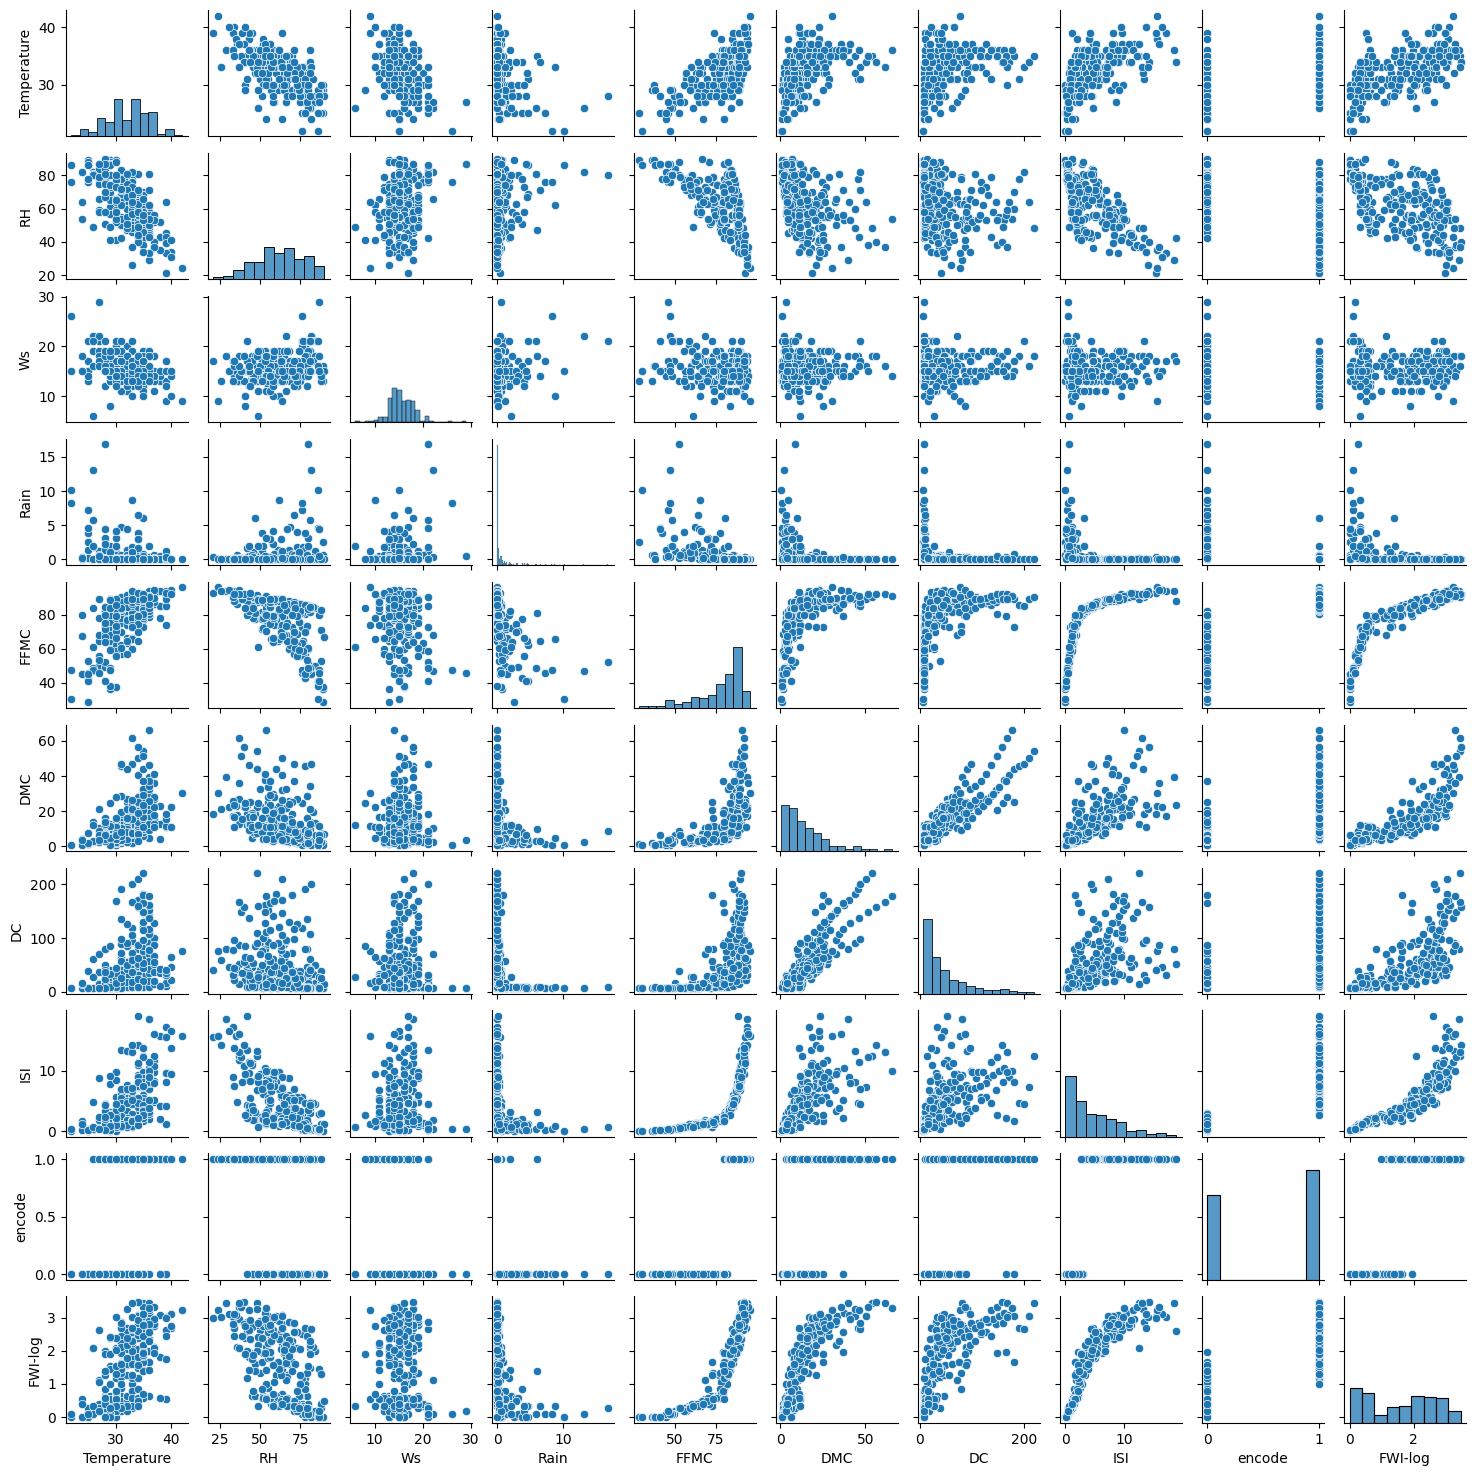

In [20]:
sns.pairplot(data=df.drop(columns=['Classes','month','day','year','FWI','BUI']), height = 1.5)

We can now pinpoint the reason, the pairplot exhibits some non-linearity. Thus a decision tree model will be trained and evaluated.

### Decision Tree Regression

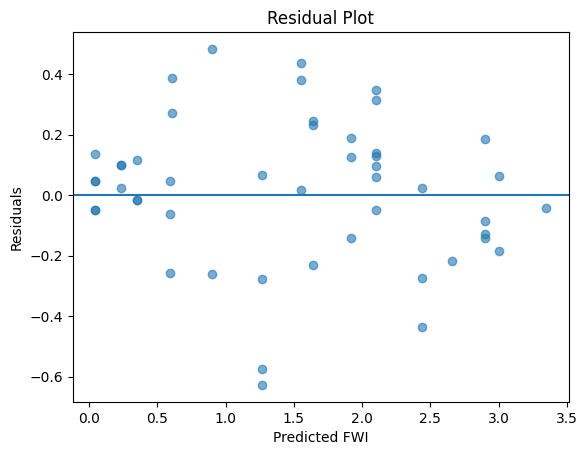

In [21]:
from sklearn.tree import DecisionTreeRegressor
params = {
    'max_depth': [1,2, 3, 4, 5, 6],        
    'min_samples_split': [15, 20, 25, 30],
    'min_samples_leaf': [8, 10, 12, 15],
}

dt = DecisionTreeRegressor(random_state = 42,)
random_search = RandomizedSearchCV(
    dt, 
    param_distributions=params, 
    n_iter=50,  
    cv=5,   
    scoring='r2', 
    n_jobs=-1,  
    random_state=42 
)

random_search.fit(X_train,Y_train) #Scaling does not matter in trees
y_pred_train = random_search.predict(X_train)
y_pred_test = random_search.predict(X_test)

residuals = Y_test - y_pred_test

plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(0)
plt.xlabel("Predicted FWI")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


In [22]:
print(f'MSE Train: {mean_squared_error(Y_train, y_pred_train)}')
print(f'MSE Test: {mean_squared_error(Y_test, y_pred_test)}')
print("Train R2:", r2_score(Y_train, y_pred_train))
print("Test R2:", r2_score(Y_test, y_pred_test))

MSE Train: 0.01585428827066311
MSE Test: 0.05586384166258455
Train R2: 0.9858558051994163
Test R2: 0.9420037306561948


---

### Conclusion

A Decision Tree model was evaluated to check whether non-linear relationships
could improve predictions, and it slightly reduced the residual pattern.
However, as is typical on smaller datasets, the tree exhibited overfitting, the training R² was  higher than the test R², indicating
that the model didn't generalize well.

Ridge regression, on the other hand, provided a strong balance between bias
and variance. It achieved high R² and low MSE on both training and test sets,
did not overfit. 

Therefore, **Ridge regression is selected as the deployed model**.


---

### Model Deployment


In [23]:
from sklearn.pipeline import Pipeline

#getting the best ridge from the RandomizedSearchCV results
best_ridge = random_search_ridge.best_estimator_
#building the pipeline
ridge_pipeline = Pipeline([('scaler', scaler),('ridge', best_ridge)]) 


In [24]:
import joblib

joblib.dump(ridge_pipeline,"../model/ridge_pipeline.joblib")

['../model/ridge_pipeline.joblib']